# Smoothing Function Testing

In [45]:
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.fft import fft, ifft



## Test Data

***
Simulated data is generated using an underlying function and adding a high level of noise to it. The goal is to predict the underlying function as best as possible using a different smoothers given the noisy data set.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Callable, Any, Union

class TestSmooth():
    def __init__(self) -> None:
        self.original_data: pd.Series
        self.noisy_data: pd.Series

        self.start_date: str
        self.end_date: str
        self.drift: float
        self.amplitude: float
        self.frequency: float
        self.noise_variance: float

        self._figsize: tuple[int,int]

    def display_generated_data(self, smoothed_data: pd.Series=None):
        # Plot both the original and noisy data
        plt.figure(figsize=(10, 6))
        if smoothed_data is not None:
            plt.plot(smoothed_data.index, smoothed_data, label='Smoothed Data', color='purple', alpha=0.7)
            plt.plot(self.original_data.index, self.original_data, label='Original Data', color='blue', alpha=0.3)
            plt.plot(self.noisy_data.index, self.noisy_data, label='Noisy Data', color='red', alpha=0.3)

            # Measures of Fit
            data = pd.concat([smoothed_data, self.original_data], axis=1).dropna()
            loss_data = {
                'L1 Error': [np.mean(abs(data.iloc[:,0] - data.iloc[:,1]))],
                'L2 Error': [np.linalg.norm(data.iloc[:,0] - data.iloc[:,1])],
                }
            display(pd.DataFrame(loss_data))
        else:
            plt.plot(self.original_data.index, self.original_data, label='Original Data', color='blue', alpha=0.7)
            plt.plot(self.noisy_data.index, self.noisy_data, label='Noisy Data', color='red', alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Original vs Noisy Time Series Data')
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_noisy_data(self, start_date: str='2022-01-01', end_date: str='2023-01-01', drift: float=0.05, amplitude: float=5, frequency: float=0.1, noise_variance: float=10):
        self.start_date = start_date
        self.end_date = end_date
        self.drift = drift
        self.amplitude = amplitude
        self.frequency = frequency
        self.noise_variance = noise_variance

        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        t = np.arange(len(dates))
        self.original_data = amplitude * np.sin(frequency * t) + drift * t

        self.original_data = pd.Series(self.original_data, index=dates, name='original_data')

        # Add noise to the original data
        noise = np.random.normal(loc=0, scale=noise_variance, size=len(dates))  # Gaussian noise with mean 0 and standard deviation 0.3
        self.noisy_data = self.original_data + noise

        self.noisy_data = pd.Series(self.noisy_data, index=dates, name='noisy_data')

        return self.original_data, self.noisy_data
    
    def test_smoothing_function(self, smoothing_function: Callable[[Union[pd.Series, pd.DataFrame], Any, Any], pd.Series]):
        try:
            smoothed_data = smoothing_function(self.noisy_data)
        except:
            smoothed_data = smoothing_function(self.noisy_data.to_frame())
        # display(smoothed_data)
        try:
            self.display_generated_data(smoothed_data.iloc[:,0])
        except:
            self.display_generated_data(smoothed_data)



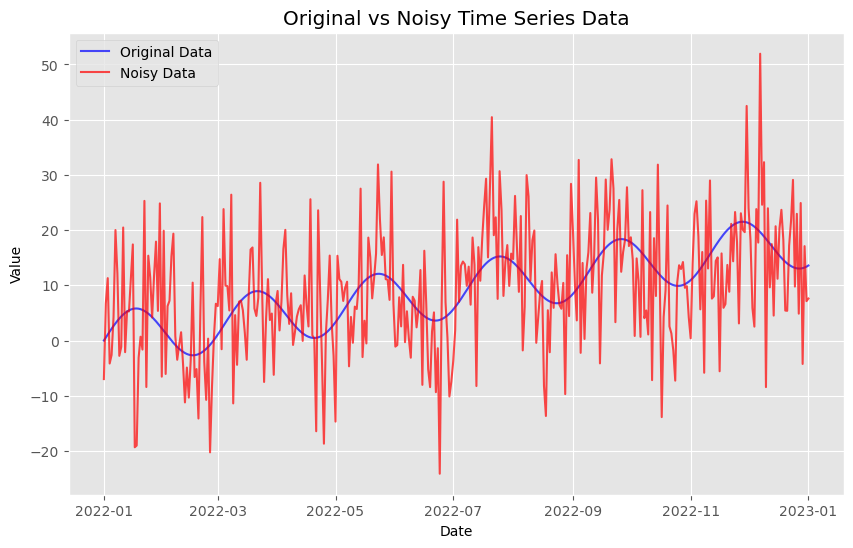

In [47]:
smoothing_fuction_tester = TestSmooth()
smoothing_fuction_tester.generate_noisy_data()
smoothing_fuction_tester.display_generated_data()

# Candidate Smoothing Functions

In [100]:
class Smooth():
    def __init__(self, combinations):
        self.combinations = combinations
        
    '''
    Smooth1: Moving Average
    Takes in a dataframe and returns the moving average based on the window size.

    Input: 

    Output:
    '''
    @staticmethod
    def smooth1(df, window=12):
        moving_avg = df.rolling(window=window).mean()
        return moving_avg
    

    '''
    Smooth2: Exponential Smoothing
    Takes in a dataframe column and returns an exponentially smoothed column. Can choose to add trend
    or seasonality fit based on parameters "is_seasonal" and "is_trend". For seasonality, can input a 
    seasonality period (with default being 12). Can choose the start and end point for the prediction values.
    
    Input: 

    Output:
    '''    
    ### RUNS INTO ISSUES WITH NAN VALUES -> DOES NOT RETURN FULL DF UNLESS NO NANs
    ### ALSO RUNS INTO ISSUE WHEN NO DATAFRAME FREQUENCY
    @staticmethod
    def smooth2(df, seasonal_periods=12, is_seasonal=None, is_trend=None):
        def exponential_smooth(col, seasonal_periods=12, is_seasonal=None, is_trend=None):
            if is_seasonal:
                is_seasonal = 'add'
            if is_trend:
                is_trend = 'add'

            model = ExponentialSmoothing(col, seasonal_periods=seasonal_periods, trend=is_trend, seasonal=is_seasonal).fit()

            return model.predict(start=0, end=len(col)-1)
        return df.apply(exponential_smooth)    

    '''
    Smooth3: Lowess Smoothing
    Takes in a dataframe column and returns an lowess smoothed column. Fraction parameter set to a
    default value of 0.1.

    Input: 

    Output:
    '''
    ### RUNS INTO ISSUES WITH NAN VALUES -> WILL PRODUCE ERROR IN RUN_MODEL METHOD
    @staticmethod
    def smooth3(df):
        def sm_lowess(col, frac=0.1):
            # smoothed = lowess(col, range(len(col)), frac)
            smoothed = pd.Series(lowess(col, range(len(col)), 0.01)[:, 1], index=col.dropna().index).reindex(col.index)
            # print(smoothed)
            return smoothed

        return df.apply(sm_lowess)
    
    '''
    Smooth4: Fourier Smoothing
    Takes in a dataframe column and returns an fourier smoothed column. Fraction parameter set to a
    default value of 0.02.

    Input: 

    Output:
    '''
    def fourier_smooth(data: pd.DataFrame, cutoff_freq=0.02):

        new_data = pd.DataFrame()
        for col in data.columns:
            fourier_transform = fft(data[col].dropna().values)
            
            n = len(data[col])
            freqs = np.fft.fftfreq(n)
            cutoff_index = int(cutoff_freq * n)
            
            fourier_transform[cutoff_index:-cutoff_index] = 0
            
            smoothed_data = np.real(ifft(fourier_transform))
            smoothed_data = pd.Series(smoothed_data, index=data[col].dropna().index)
            new_data[col] = smoothed_data
        new_data.index = data.index
        return new_data

## Testing Smooth1: Moving Average

,L1 Error,L2 Error
0,2.853482,69.070186


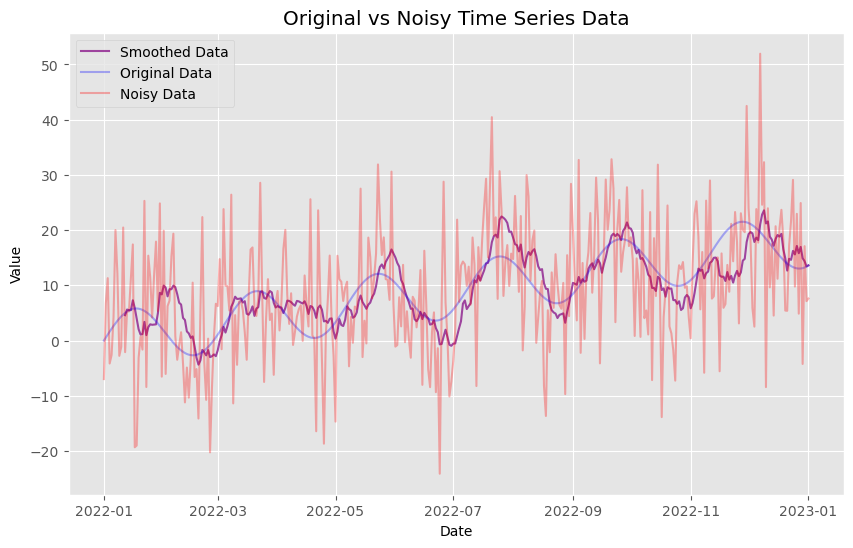

In [49]:
smoothing_fuction_tester.test_smoothing_function(Smooth.smooth1)

,L1 Error,L2 Error
0,2.774179,67.819579


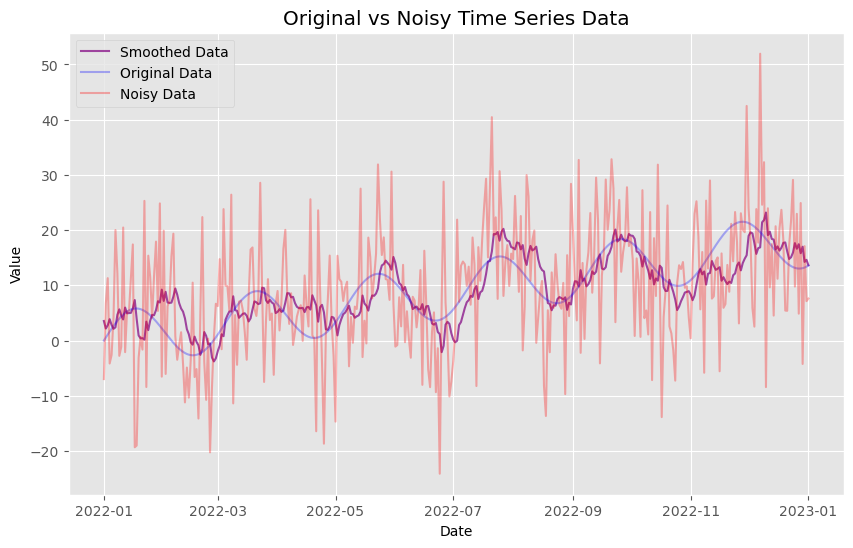

In [50]:
smoothing_fuction_tester.test_smoothing_function(Smooth.smooth2)

,L1 Error,L2 Error
0,1.957907,45.302337


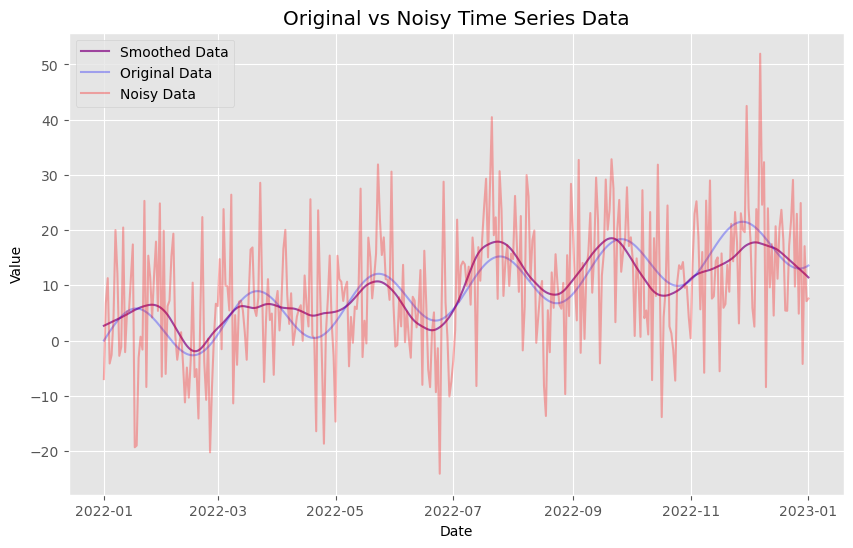

In [51]:
smoothing_fuction_tester.test_smoothing_function(Smooth.smooth3)

,L1 Error,L2 Error
0,1.86101,43.797821


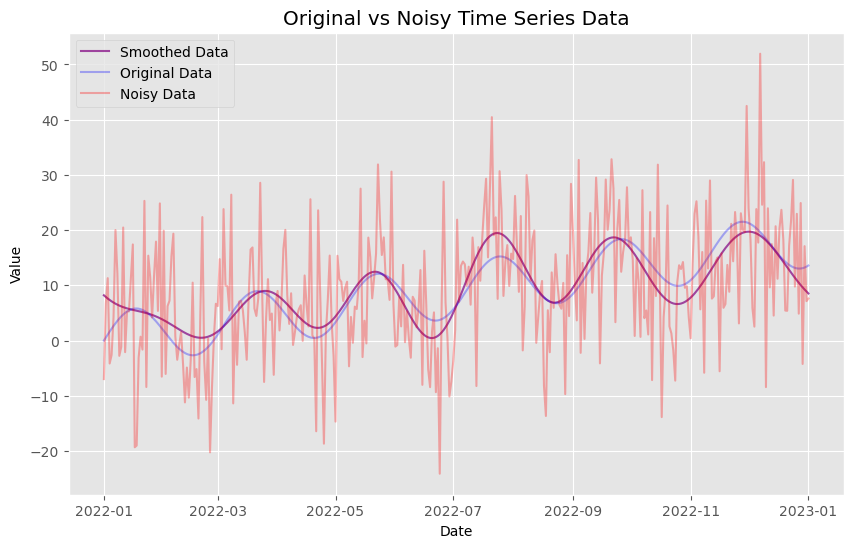

In [52]:
smoothing_fuction_tester.test_smoothing_function(Smooth.fourier_smooth)

# Testing on Data
***

In [53]:
import datetime 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pipeline

In [54]:
# Survey Aggregate data and indicator data
df_agg, df_ind = pipeline.read_and_format_data()

In [55]:
df_agg

,Q3A1666,Q3A1667,Q3A1668,Q3A1669,Q3A1670,Q3A1671,Q3A1672,Q3A1673,Q3A1674,Q3A1675,...,Q3053A8020,Q3053A8021,Q3053A8022,Q3053A8023,Q3053A8024,Q3053A8025,Q3053A8026,Q3053A8027,Q3053A8028,Q3053A8029
2019-07-23,0.473846,0.090769,0.189231,0.868462,0.456154,0.492308,0.272308,0.792308,0.322308,0.227692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24,0.412727,0.098182,0.201818,0.833939,0.445455,0.518788,0.249697,0.810909,0.312121,0.260606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19,0.303502,0.085603,0.210117,0.801556,0.357977,0.470817,0.210117,0.813230,0.315175,0.307393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,0.448763,0.109541,0.280919,0.886926,0.553004,0.563604,0.312721,0.853357,0.397527,0.268551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-24,0.429719,0.074297,0.174699,0.869478,0.449799,0.467871,0.230924,0.805221,0.315261,0.242972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,0.293605,0.046512,0.186047,0.770349,0.250000,0.517442,0.087209,0.706395,0.203488,0.281977,...,0.103267,0.266596,0.033720,0.070601,0.037935,0.069547,0.106428,0.064278,0.015806,0.033720
2023-10-05,0.274939,0.029197,0.167883,0.781022,0.279805,0.479319,0.058394,0.688564,0.233577,0.250608,...,0.073235,0.278989,0.024412,0.080209,0.034002,0.074978,0.107236,0.070619,0.017437,0.051439
2023-10-06,0.307902,0.032698,0.198910,0.782016,0.253406,0.476839,0.079019,0.653951,0.207084,0.237057,...,0.085087,0.291857,0.037511,0.068618,0.021958,0.068618,0.124428,0.062214,0.018298,0.036597
2023-10-07,0.283069,0.039683,0.177249,0.730159,0.219577,0.468254,0.082011,0.666667,0.240741,0.269841,...,0.078283,0.255892,0.047138,0.078283,0.037879,0.064815,0.129630,0.064815,0.026094,0.038721


In [56]:
df_agg

,Q3A1666,Q3A1667,Q3A1668,Q3A1669,Q3A1670,Q3A1671,Q3A1672,Q3A1673,Q3A1674,Q3A1675,...,Q3053A8020,Q3053A8021,Q3053A8022,Q3053A8023,Q3053A8024,Q3053A8025,Q3053A8026,Q3053A8027,Q3053A8028,Q3053A8029
2019-07-23,0.473846,0.090769,0.189231,0.868462,0.456154,0.492308,0.272308,0.792308,0.322308,0.227692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24,0.412727,0.098182,0.201818,0.833939,0.445455,0.518788,0.249697,0.810909,0.312121,0.260606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19,0.303502,0.085603,0.210117,0.801556,0.357977,0.470817,0.210117,0.813230,0.315175,0.307393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,0.448763,0.109541,0.280919,0.886926,0.553004,0.563604,0.312721,0.853357,0.397527,0.268551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-24,0.429719,0.074297,0.174699,0.869478,0.449799,0.467871,0.230924,0.805221,0.315261,0.242972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,0.293605,0.046512,0.186047,0.770349,0.250000,0.517442,0.087209,0.706395,0.203488,0.281977,...,0.103267,0.266596,0.033720,0.070601,0.037935,0.069547,0.106428,0.064278,0.015806,0.033720
2023-10-05,0.274939,0.029197,0.167883,0.781022,0.279805,0.479319,0.058394,0.688564,0.233577,0.250608,...,0.073235,0.278989,0.024412,0.080209,0.034002,0.074978,0.107236,0.070619,0.017437,0.051439
2023-10-06,0.307902,0.032698,0.198910,0.782016,0.253406,0.476839,0.079019,0.653951,0.207084,0.237057,...,0.085087,0.291857,0.037511,0.068618,0.021958,0.068618,0.124428,0.062214,0.018298,0.036597
2023-10-07,0.283069,0.039683,0.177249,0.730159,0.219577,0.468254,0.082011,0.666667,0.240741,0.269841,...,0.078283,0.255892,0.047138,0.078283,0.037879,0.064815,0.129630,0.064815,0.026094,0.038721


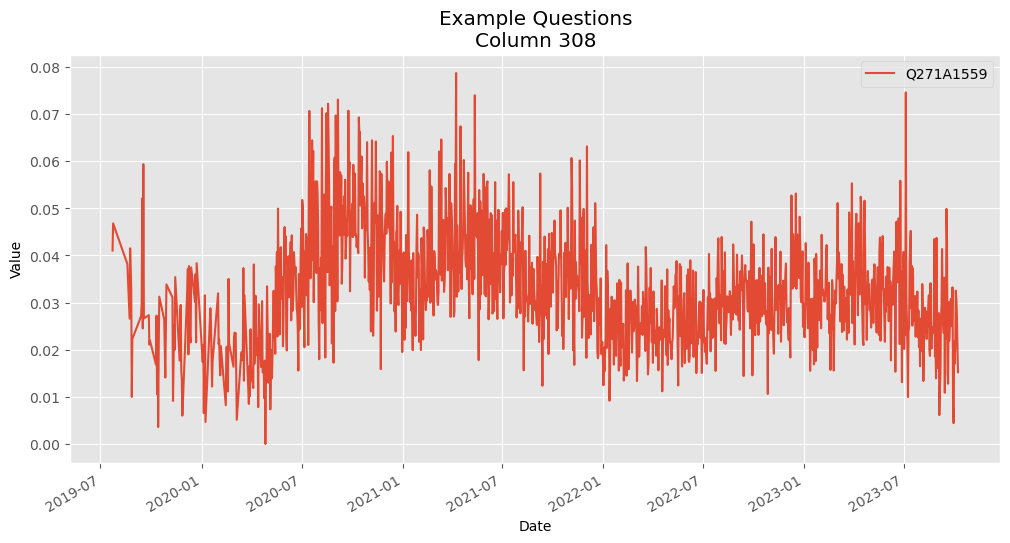

In [57]:
random_col = np.random.randint(0,df_agg.shape[1])
demo_col = 615
question_df = df_agg.iloc[:,[demo_col]].ffill().bfill()
question_df.plot.line(xlabel='Date', ylabel='Value', title=f'Example Questions\nColumn {random_col}', figsize=(12,6))
plt.show()

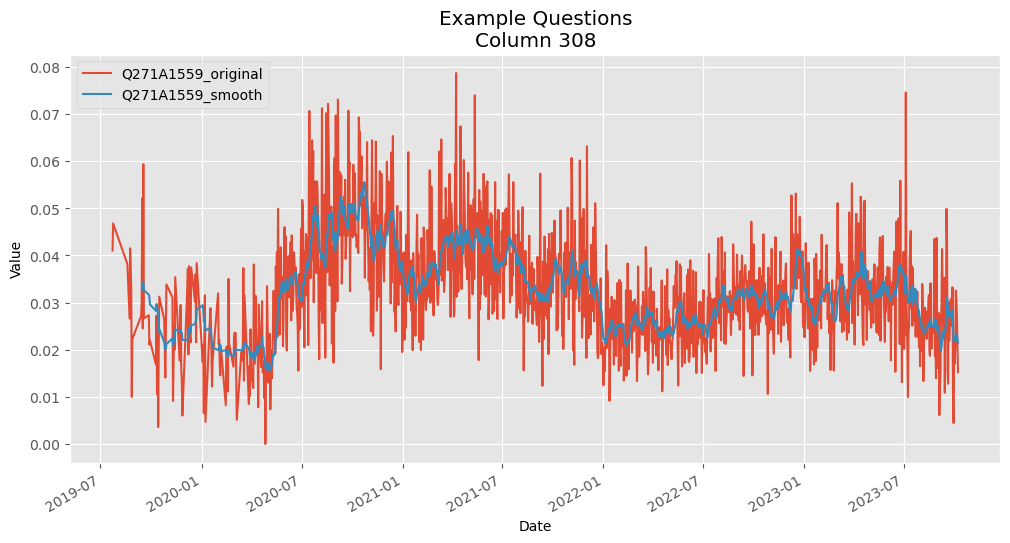

In [58]:
# Smooth.smooth3(df_agg.iloc[:,random_col])
smoothed_df = Smooth.smooth1(
    question_df
)
display_df = question_df.merge(smoothed_df, how='left', left_index=True, right_index=True, suffixes=('_original', '_smooth'))
display_df.plot.line(xlabel='Date', ylabel='Value', title=f'Example Questions\nColumn {random_col}', figsize=(12,6))
plt.show()

/Users/alexhuang/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


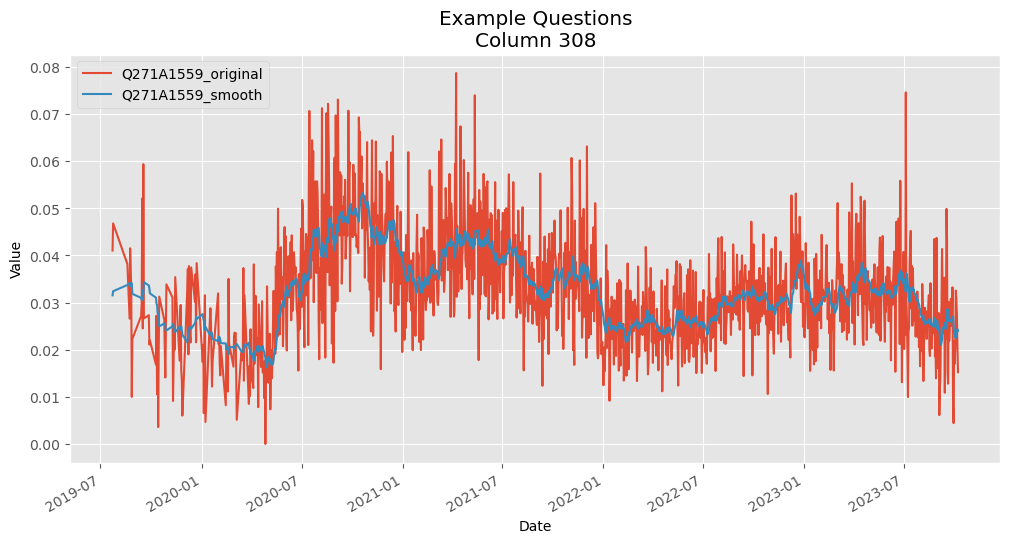

In [59]:
# Smooth.smooth3(df_agg.iloc[:,random_col])
smoothed_df = Smooth.smooth2(
    question_df
)
display_df = question_df.merge(smoothed_df, how='left', left_index=True, right_index=True, suffixes=('_original', '_smooth'))
display_df.plot.line(xlabel='Date', ylabel='Value', title=f'Example Questions\nColumn {random_col}', figsize=(12,6))
plt.show()

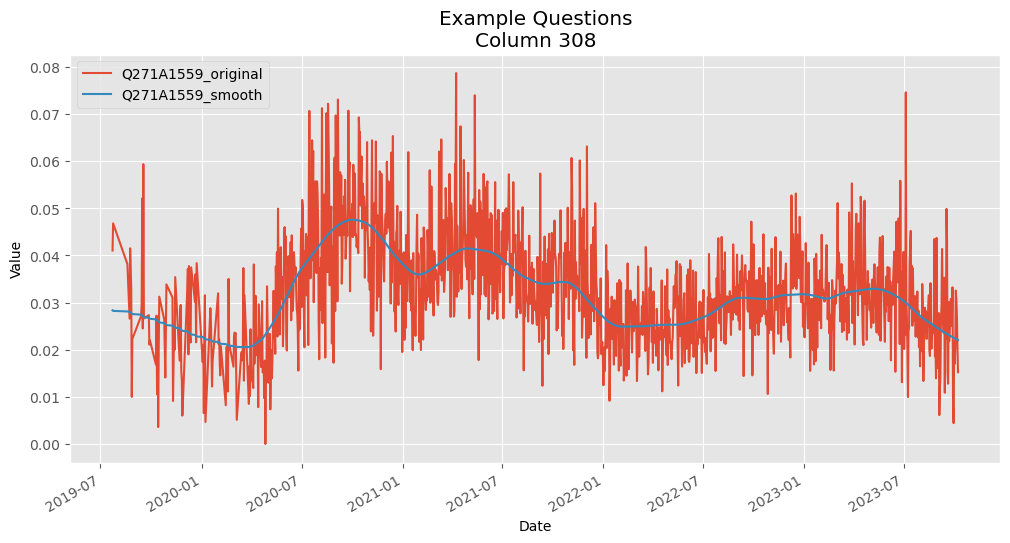

In [60]:
# Smooth.smooth3(df_agg.iloc[:,random_col])
smoothed_df = Smooth.smooth3(
    question_df
)
display_df = question_df.merge(smoothed_df, how='left', left_index=True, right_index=True, suffixes=('_original', '_smooth'))
display_df.plot.line(xlabel='Date', ylabel='Value', title=f'Example Questions\nColumn {random_col}', figsize=(12,6))
plt.show()

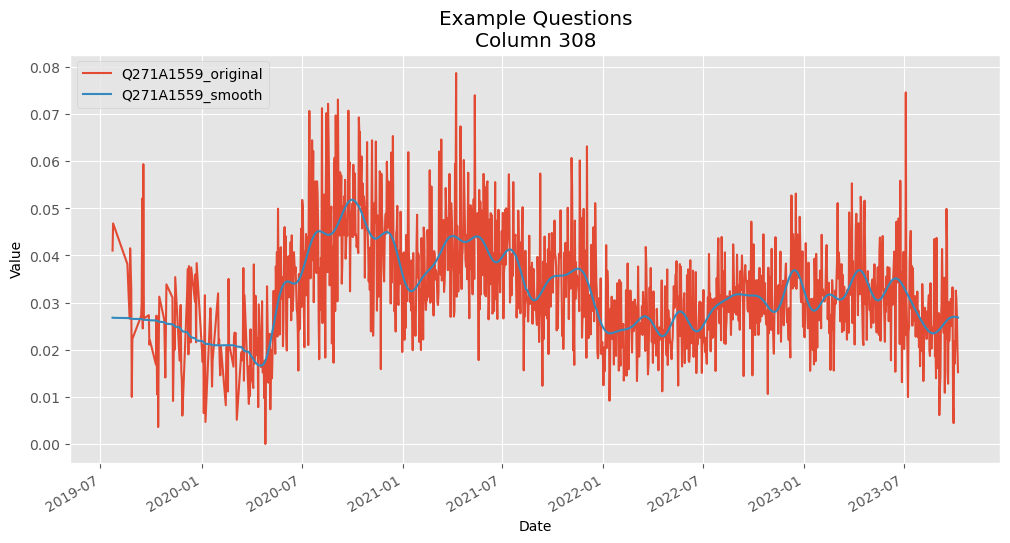

In [61]:
# Smooth.smooth3(df_agg.iloc[:,random_col])
smoothed_df = Smooth.fourier_smooth(
    question_df
)
display_df = question_df.merge(smoothed_df, how='left', left_index=True, right_index=True, suffixes=('_original', '_smooth'))
display_df.plot.line(xlabel='Date', ylabel='Value', title=f'Example Questions\nColumn {random_col}', figsize=(12,6))
plt.show()

# Out of Sample Testing: Smoothing Functions
***

In [95]:
col = df_agg['Q3053A8020']
display(col)
# display(lowess(col, range(len(col)), 0.01))
# display(lowess(col, range(len(col)), 0.01).shape)
pd.Series(lowess(col, range(len(col)), 0.01)[:, 1], index=col.dropna().index).reindex(col.index)
# display(col.dropna().index)
# col

2019-07-23         NaN
2019-07-24         NaN
2019-08-19         NaN
2019-08-23         NaN
2019-08-24         NaN
                ...   
2023-10-04    0.103267
2023-10-05    0.073235
2023-10-06    0.085087
2023-10-07    0.078283
2023-10-08    0.089765
Name: Q3053A8020, Length: 1361, dtype: float64

2019-07-23         NaN
2019-07-24         NaN
2019-08-19         NaN
2019-08-23         NaN
2019-08-24         NaN
                ...   
2023-10-04    0.103267
2023-10-05    0.073235
2023-10-06    0.085087
2023-10-07    0.078283
2023-10-08    0.089765
Length: 1361, dtype: float64

In [98]:
Smooth.smooth3(df_agg)

,Q3A1666,Q3A1667,Q3A1668,Q3A1669,Q3A1670,Q3A1671,Q3A1672,Q3A1673,Q3A1674,Q3A1675,...,Q3053A8020,Q3053A8021,Q3053A8022,Q3053A8023,Q3053A8024,Q3053A8025,Q3053A8026,Q3053A8027,Q3053A8028,Q3053A8029
2019-07-23,0.444621,0.092784,0.199887,0.854868,0.453435,0.494521,0.261644,0.810743,0.314934,0.251683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24,0.442181,0.089676,0.194083,0.854953,0.451622,0.493839,0.254709,0.808895,0.314132,0.250888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19,0.439874,0.086729,0.188610,0.854862,0.449631,0.493577,0.247982,0.806883,0.313695,0.250172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,0.437689,0.083962,0.183685,0.854588,0.447411,0.493676,0.241427,0.804914,0.313699,0.249738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-24,0.435684,0.081366,0.179397,0.854321,0.444946,0.494054,0.235061,0.803169,0.314228,0.249599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,0.308043,0.036692,0.182256,0.770136,0.246187,0.492610,0.075288,0.695979,0.208747,0.272889,...,0.103267,0.266596,0.033720,0.070601,0.037935,0.069547,0.106428,0.064278,0.015806,0.033720
2023-10-05,0.304201,0.035991,0.181261,0.771603,0.245228,0.491148,0.075603,0.691019,0.211981,0.274219,...,0.073235,0.278989,0.024412,0.080209,0.034002,0.074978,0.107236,0.070619,0.017437,0.051439
2023-10-06,0.300025,0.035227,0.180194,0.772979,0.244165,0.489027,0.075828,0.685893,0.215414,0.274978,...,0.085087,0.291857,0.037511,0.068618,0.021958,0.068618,0.124428,0.062214,0.018298,0.036597
2023-10-07,0.295675,0.034442,0.179142,0.774161,0.242825,0.486273,0.076030,0.680586,0.219046,0.275258,...,0.078283,0.255892,0.047138,0.078283,0.037879,0.064815,0.129630,0.064815,0.026094,0.038721


In [101]:
Smooth.fourier_smooth(df_agg)

/var/folders/tl/2mnl94rs3r36jtm93n995fhr0000gn/T/ipykernel_82377/3934579411.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[col] = smoothed_data
/var/folders/tl/2mnl94rs3r36jtm93n995fhr0000gn/T/ipykernel_82377/3934579411.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[col] = smoothed_data
/var/folders/tl/2mnl94rs3r36jtm93n995fhr0000gn/T/ipykernel_82377/3934579411.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

,Q3A1666,Q3A1667,Q3A1668,Q3A1669,Q3A1670,Q3A1671,Q3A1672,Q3A1673,Q3A1674,Q3A1675,...,Q3053A8020,Q3053A8021,Q3053A8022,Q3053A8023,Q3053A8024,Q3053A8025,Q3053A8026,Q3053A8027,Q3053A8028,Q3053A8029
2019-07-23,0.368731,0.060264,0.184907,0.808982,0.326330,0.482168,0.154177,0.751662,0.266602,0.264802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24,0.374360,0.061942,0.184672,0.812753,0.332352,0.481946,0.159910,0.756613,0.270873,0.263627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-19,0.379911,0.063602,0.184359,0.816447,0.338324,0.481622,0.165587,0.761468,0.275063,0.262366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,0.385358,0.065234,0.183975,0.820049,0.344219,0.481207,0.171178,0.766204,0.279154,0.261032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-24,0.390679,0.066832,0.183527,0.823548,0.350009,0.480711,0.176653,0.770800,0.283127,0.259641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,0.340308,0.051868,0.184713,0.789468,0.296394,0.481421,0.125732,0.726268,0.244735,0.268923,...,0.084737,0.278937,0.036211,0.073103,0.035984,0.068112,0.108857,0.076661,0.014722,0.038684
2023-10-05,0.345943,0.053522,0.184952,0.793409,0.302274,0.481844,0.131293,0.731354,0.249109,0.268373,...,0.087953,0.278965,0.034780,0.072881,0.032515,0.069559,0.116042,0.069363,0.016248,0.037400
2023-10-06,0.351629,0.055196,0.185086,0.797346,0.308232,0.482124,0.136947,0.736460,0.253503,0.267675,...,0.096152,0.268175,0.033673,0.071033,0.032073,0.070378,0.120717,0.060099,0.017148,0.035079
2023-10-07,0.357340,0.056883,0.185120,0.801264,0.314244,0.482265,0.142666,0.741562,0.257897,0.266839,...,0.107988,0.249091,0.033342,0.067199,0.035812,0.070069,0.119605,0.052288,0.017705,0.032197
